In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix, accuracy_score ,precision_score ,recall_score ,f1_score


In [75]:
data = pd.read_csv(r"E:\STUDY MATERIALS\IIT MADRAS\SEMESTER 2\ML OPs\DA5402-ML_Ops\Assignment 1\manual_mlops_project\data\raw\ai4i2020.csv")

df = pd.DataFrame(data)
train_test_df = df.iloc[:7000,:].copy()
production_df = df.iloc[7000:].copy()

print(train_test_df.shape)
print(production_df.shape)

(7000, 14)
(3000, 14)


In [76]:
print(train_test_df['Machine failure'].value_counts(normalize=True))
print("="*40)
print(production_df['Machine failure'].value_counts(normalize=True))

Machine failure
0    0.960286
1    0.039714
Name: proportion, dtype: float64
Machine failure
0    0.979667
1    0.020333
Name: proportion, dtype: float64


In [77]:
production_df.to_csv(r"E:\STUDY MATERIALS\IIT MADRAS\SEMESTER 2\ML OPs\DA5402-ML_Ops\Assignment 1\manual_mlops_project\data\production\production_data.csv",index=False)

In [78]:
train_test_df = train_test_df.drop(['UDI','Product ID','TWF', 'HDF', 'PWF', 'OSF', 'RNF'],axis=1)

In [79]:
X = train_test_df.drop('Machine failure',axis=1)
y = train_test_df['Machine failure']

In [119]:
X_train,X_test,y_train,y_test = train_test_split(X, y, 
                                                 stratify = y, 
                                                 test_size=0.2, 
                                                 random_state=42 )

In [120]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)


(5600, 6)
(1400, 6)
(5600,)
(1400,)


In [121]:
print(y_train.value_counts(normalize=True))
print("="*40)
print(y_test.value_counts(normalize=True))


Machine failure
0    0.960357
1    0.039643
Name: proportion, dtype: float64
Machine failure
0    0.96
1    0.04
Name: proportion, dtype: float64


In [122]:
numerical_features = X_train.select_dtypes(include='number').columns
cat_features = X_train.select_dtypes(include='object').columns

print(numerical_features)
print(cat_features)

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')
Index(['Type'], dtype='object')


In [123]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numerical_features),
        ('cat',OneHotEncoder(drop='first'),cat_features)
    ]
)

In [124]:
log_model = Pipeline(
    steps= [
        ('preprocessing',preprocessor),
        ('clasiifier',LogisticRegression(class_weight='balanced' ,max_iter=1000))
    ]
)

log_model.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Type'], dtype='object'))])),
                ('clasiifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [125]:
y_test_pred = log_model.predict(X_test)
y_test_prob = log_model.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_test_pred))
print("validation ROC-AUC",roc_auc_score(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1344
           1       0.15      0.71      0.25        56

    accuracy                           0.82      1400
   macro avg       0.57      0.77      0.57      1400
weighted avg       0.95      0.82      0.87      1400

validation ROC-AUC 0.7719494047619049


Text(0.5, 1.0, 'Condusion Matrix')

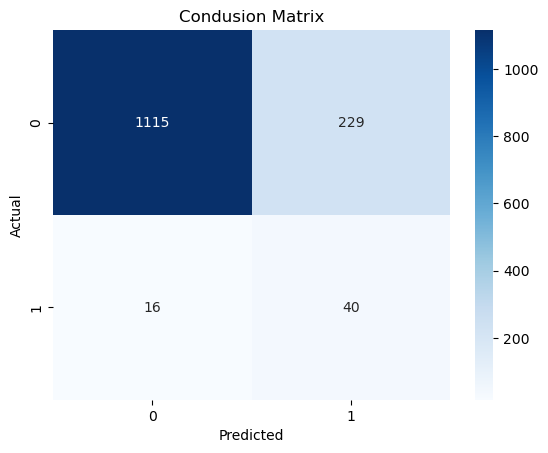

In [126]:
cm = confusion_matrix(y_test,y_test_pred)

sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Condusion Matrix")

In [127]:
print("Accuracy : ",accuracy_score(y_test,y_test_pred))
print("Precision : ",precision_score(y_test,y_test_pred))
print("Recall : ",recall_score(y_test,y_test_pred))
print("F1-score : ",f1_score(y_test,y_test_pred))


Accuracy :  0.825
Precision :  0.14869888475836432
Recall :  0.7142857142857143
F1-score :  0.24615384615384617


In [128]:
rf_model = Pipeline(
    steps= [
        ('preprocessing',preprocessor),
        ('classifier',RandomForestClassifier(
                                             class_weight='balanced',
                                             random_state=42))
    ]
)


In [129]:
param_grid = {
    'classifier__n_estimators' : [100,200],
    'classifier__max_depth': [None,10,20],
    'classifier__min_samples_split' : [2,5],
    'classifier__min_samples_leaf' : [1,2]
}


cv = StratifiedKFold(
    n_splits=5,
    shuffle= True,
    random_state=42                 
)

grid_search = GridSearchCV(
    estimator = rf_model,
    param_grid= param_grid,
    cv=cv,
    scoring='recall',
    n_jobs=1,
    verbose=2
)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=N

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Type'], dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='recall', verbose=2)

In [136]:
best_model =grid_search.best_estimator_
print('Best Parameters : ',grid_search.best_params_ )
print('Best CV score : ',grid_search.best_score_ )

Best Parameters :  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV score :  0.6934343434343434


In [139]:
y_train_prob = cross_val_predict(
    best_model,
    X_train,
    y_train,
    cv=StratifiedKFold(5),
    method='predict_proba'
)[:,1]

In [145]:

thresholds = [0.3]

for t in thresholds:
    preds = (y_train_prob >= t).astype(int)
    print(t,'  ',
          recall_score(y_train, preds),'  ',
          precision_score(y_train, preds))


0.3    0.8513513513513513    0.532394366197183


In [146]:


y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:,1]

print("Threshold 0.5")
print(classification_report(y_test,y_test_pred))
print("roc-auc score : ",roc_auc_score(y_test,y_test_pred))

Threshold 0.5
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1344
           1       0.56      0.57      0.57        56

    accuracy                           0.96      1400
   macro avg       0.77      0.78      0.77      1400
weighted avg       0.97      0.96      0.97      1400

roc-auc score :  0.7764136904761905


Text(0.5, 1.0, 'Coufsion Matrix (T = 0.5) ')

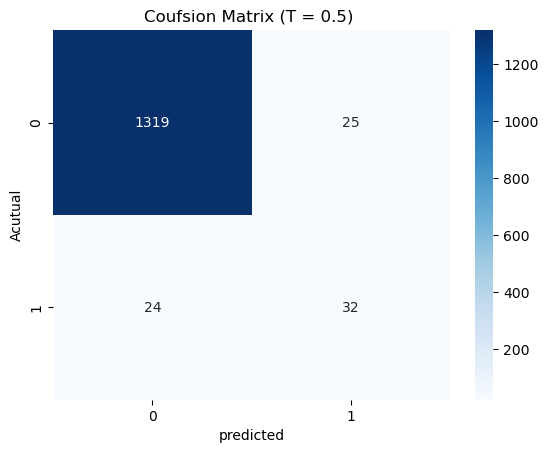

In [153]:
cm = confusion_matrix(y_test,y_test_pred)

sns.heatmap(cm,fmt='d',annot=True,cmap='Blues')
plt.xlabel("predicted")
plt.ylabel("Acutual")
plt.title("Coufsion Matrix (T = 0.5) ")

In [149]:
y_custom_pred=(y_test_prob>0.3).astype(int)

print("Threshold = 0.3")
print(classification_report(y_test,y_custom_pred))
print("roc-auc score : ",roc_auc_score(y_test,y_custom_pred))

Threshold = 0.3
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1344
           1       0.43      0.70      0.53        56

    accuracy                           0.95      1400
   macro avg       0.71      0.83      0.75      1400
weighted avg       0.96      0.95      0.96      1400

roc-auc score :  0.8292410714285714


Text(0.5, 1.0, 'Coufsion Matrix (T = 0.3) ')

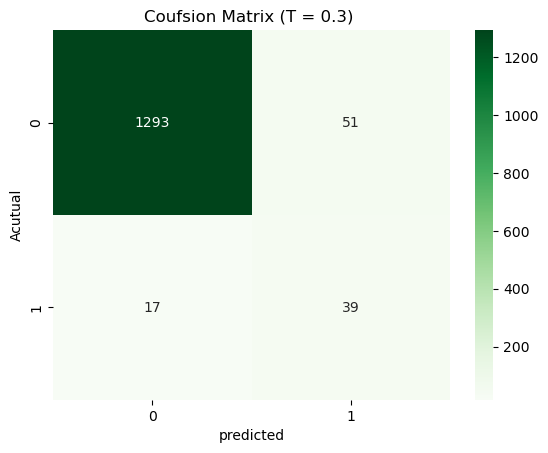

In [155]:
cn = confusion_matrix(y_test,y_custom_pred)

sns.heatmap(cn,annot=True,fmt='d',cmap="Greens")
plt.xlabel("predicted")
plt.ylabel("Acutual")
plt.title("Coufsion Matrix (T = 0.3) ")